# Introduction to this project 
This dataset contains 11 variables:\
step: maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation). \
type: CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.\
amount: amount of the transaction in local currency.\
nameOrig: customer who started the transaction\
oldbalanceOrg: initial balance before the transaction\
newbalanceOrig: new balance after the transaction.\
nameDest: customer who is the recipient of the transaction\
oldbalanceDest: initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).\
newbalanceDest: new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).\
isFraud: This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.\
isFlaggedFraud: The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.\



In [2]:
# load libraries 
import numpy as np # linear algebra
import pandas as pd # Data processing
import matplotlib.pyplot as plt #Data visualization
import seaborn as sns # Data visualization
from sklearn.model_selection import train_test_split, RandomizedSearchCV # Cross-validation, splitting sets
from sklearn.preprocessing import MinMaxScaler #Data scaling
import xgboost as xgb #Extreme Gradient Boosting
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score #Metrics
import matplotlib.ticker as mticker # Label format 
from matplotlib.ticker import ScalarFormatter # Label format
from matplotlib.ticker import FuncFormatter
from sklearn.impute import SimpleImputer

Import the dataset and some exploration 

In [4]:
# import the dataset 
df = pd.read_csv('data.csv')


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [12]:
# explore the dataset
df.head()
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

# Section 1: Exploratory Data Analysis

In [15]:
df.describe(include='all')

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6362620,6.362620e+06,6362620,6.362620e+06,6.362620e+06,6362620,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
unique,NaN,5,NaN,6353307,NaN,NaN,2722362,NaN,NaN,NaN,NaN
top,NaN,CASH_OUT,NaN,C2098525306,NaN,NaN,C1286084959,NaN,NaN,NaN,NaN
freq,NaN,2237500,NaN,3,NaN,NaN,113,NaN,NaN,NaN,NaN
mean,2.433972e+02,NaN,1.798619e+05,NaN,8.338831e+05,8.551137e+05,NaN,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,NaN,6.038582e+05,NaN,2.888243e+06,2.924049e+06,NaN,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,NaN,0.000000e+00,NaN,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,NaN,1.338957e+04,NaN,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,NaN,7.487194e+04,NaN,1.420800e+04,0.000000e+00,NaN,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,NaN,2.087215e+05,NaN,1.073152e+05,1.442584e+05,NaN,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


## 1.1 Target variable exploration:

The dataset is highly imbalanced, where the vast majority (99.87%) of cases are classified as fraud, and 99.99% of the transactions are classified as flagged fraud
\
Question: Is a transaction labeled as flagged fraud actually fraudulent? - Yes \
Is a transaction labeled as fraud actually flagged fraudulent?  - No 


In [76]:
def create_pie_chart(dataframe, column_name):
    color = sns.color_palette('RdGy_r')
    plot_df = dataframe[column_name].value_counts()
    plot_df.plot(kind="pie")
    plt.show() # a pie chart function 

    

In [74]:
def create_barplot(dataframe, column_name):
    color = sns.color_palette('RdGy_r')
    int_level = dataframe[column_name].value_counts()
    plt.figure(figsize=(8,4))
    sns.barplot(int_level.index, int_level.values, alpha=0.8, color=color[1])
    plt.ylabel('Number of Occurrences', fontsize=12)
    plt.xlabel('column_name', fontsize=12)
    plt.show()

In [36]:
def create_freq_tables(dataframe, column_name,desc):
    # one way frequency table for the species column. 
    freq_table = pd.crosstab(dataframe[column_name], desc) 
  
    # frequency table in proportion of species 
    freq_table= freq_table/len(dataframe) 
    print(freq_table)
    

In [42]:
print(create_freq_tables(df,'isFraud','no of fraud'))
print(create_freq_tables(df,'isFlaggedFraud','flagged fraud'))

col_0    no of fraud
isFraud             
0           0.998709
1           0.001291
None
col_0           flagged fraud
isFlaggedFraud               
0                    0.999997
1                    0.000003
None


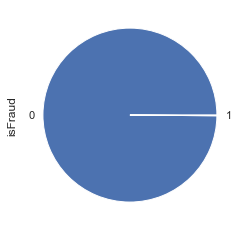

In [77]:
create_pie_chart(df, "isFraud")

## 1.2: important relationship between features and target variable

AxesSubplot(0.125,0.125;0.775x0.755)


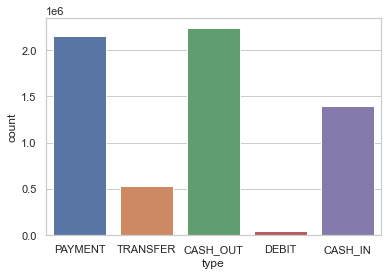

In [78]:
print(sns.countplot(x='type',data=df))

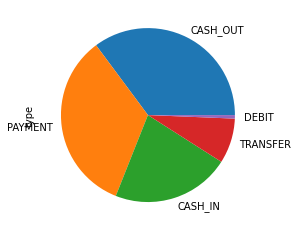

In [53]:
create_pie_chart(df, "type")

In [67]:
def my_catplot(dataframe, column_name,feature=None, ax=None):
    sns.countplot(data=dataframe[:100000], x=feature, hue=column_name, palette=(palette[0], palette[-1]), ax=ax)
    ax.set_xlabel('Number of Observations')
    ax.set_ylabel(f'{feature}')

In [90]:
def my_histplot(dataframe, column_name,feature=None, ax=None):
    sns.histplot(data=dataframe[:100000], 
                         x=feature, 
                         hue=column_name, 
                         kde=True, 
                         element='step', 
                         palette=(palette[0], 
                                  palette[-1]), 
                         ax=ax,
                         log_scale=True)
    ax.set_ylabel('Number of Observations')
    ax.set_xlabel(f'{feature}')
    mean_value_f = dataframe[dataframe[column_name]==False][feature].mean()
    mean_value_t = dataframe[dataframe[column_name]==True][feature].mean()
    ax.axvline(x=mean_value_f, 
               color=palette[0])
    ax.axvline(x=mean_value_t, 
                color=palette[-1])
    ax.annotate(f'Mean {feature}\n for regular transactions: ${mean_value_f:,.2f}', 
                 xy=(0.1, 0.5),
                 xycoords='axes fraction',
                 font='roboto',
                 fontstyle='italic')
    ax.annotate(f'Mean {feature}\n for fraudulent transactions: ${mean_value_t:,.2f}', 
                 xy=(0.1, 0.3),
                 xycoords='axes fraction',
                 font='roboto',
                 fontstyle='italic')

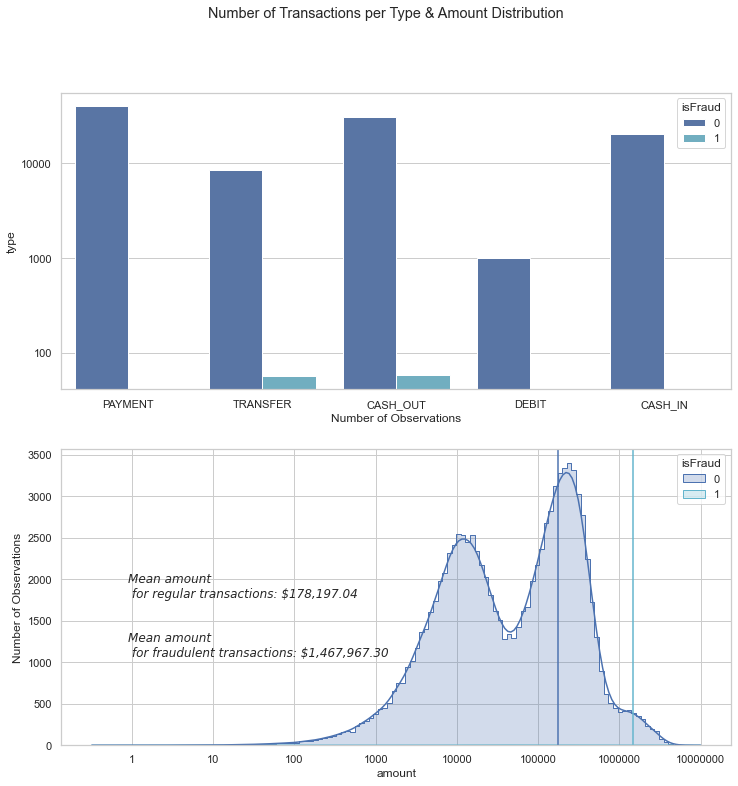

In [91]:
#Setting styles for charts
sns.set_style('whitegrid')
sns.set_context('notebook')
sns.set_palette('deep')

palette = sns.color_palette('deep')

#Creating visualizations
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
fig.suptitle('Number of Transactions per Type & Amount Distribution')

my_catplot(dataframe=df,column_name='isFraud',feature='type',ax= ax1)
ax1.set_yscale('log')
ax1.yaxis.set_major_formatter(mticker.ScalarFormatter())

my_histplot(dataframe=df,column_name='isFraud',feature='amount', ax= ax2)
ax2.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax2.ticklabel_format(style='plain', axis='x')


plt.show()

Based on these visualizations, I can draw the following conclusions:

1. The majority of fraudulent transactions are concentrated within the Cash-Out and Transfer categories, which aligns with our expectations given the nature of financial fraud.
2. It is evident that the average amount for fraudulent transactions significantly exceeds that of regular transactions, indicating that fraudsters tend to target higher-value transactions.
3. The dataset exhibits a substantial class imbalance, a common characteristic in financial fraud detection datasets. While this imbalance presents a challenge for model tuning, it is an important aspect to consider when building effective fraud detection models.

## 1.3: Missing values 
There are no missing values. 

In [49]:
display(df.isna().sum())

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

We have a clean dataset and there is no missing values

# Section 2: Data Preprocessing
### Prepare the dataset for training and validation  

This section includes several parts: 
1. One-hot encoding for the categorical variable "type"
2. Remove Irrelevant Columns \
Columns such as "nameOrig" "nameDest" "step" should be assumed to be trrelevant features. "isFlaggedFraud" can lead to data leakage problem, as transactions labeled as "flagged fraud" are all fraud. 
3. Split the dataset into train and test







In [110]:
# convert the categorical variable to numerical format using one-hot encoding 
df = pd.get_dummies(df, columns=['type'])


In [111]:
# Remove Irrelevant Columns 
X = df.drop(["isFraud","isFlaggedFraud","step","nameOrig","nameDest"],axis="columns")
Y = df["isFraud"]

Since the dataset is too big (6362620 entries), it took me forever to proform the grid search corss-validation to find out the best parameters.Therefore, I subset the dataset to include only 1% of the total entries. 

In [276]:
X_subset, _, Y_subset, _ = train_test_split(X, Y, test_size= 0.99, random_state=42, stratify=Y)

# split the new subset into training and test sets 
X_train,X_test,Y_train,Y_test=train_test_split(X_subset,Y_subset,train_size = 0.8,stratify=Y_subset,random_state=27)
#to see the lenght:
print("X_train length",len(X_train))
print("X_test length",len(X_test))

X_train length 50900
X_test length 12726


In [277]:
# test if the dataset is stratified 
print(Y_train.value_counts())
print(Y_test.value_counts())


0    50834
1       66
Name: isFraud, dtype: int64
0    12710
1       16
Name: isFraud, dtype: int64


# Section 3: Modeling 

## 3.1 logistic model

In [279]:
from sklearn.linear_model import LogisticRegression
# logistic regression 
model_log = LogisticRegression()

In [280]:
# model fit (train on the training data)
model_log.fit(X_train, Y_train)

LogisticRegression()

In [296]:
# make a prediction
Y_pred_log = model_log.predict(X_test)

In [285]:
# Define a function to evaluate a model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    report=classification_report(Y_test, y_pred)
    return print(report)


In [286]:
evaluate_model(model_log, X_test, Y_test)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     12710
           1       0.03      0.56      0.06        16

    accuracy                           0.98     12726
   macro avg       0.52      0.77      0.53     12726
weighted avg       1.00      0.98      0.99     12726



In [292]:
def evaluate_model_roc_pr(model,X_test,y_test):
    y_pred = model.predict(X_test)
    
    # AUC-ROC: The AUC-ROC measures the model's ability to distinguish between positive and negative instances. 
    roc_auc = metrics.roc_auc_score(Y_test, y_pred)

    # AUC-PR: The AUC-PR measures the precision-recall trade-off. It is a useful metric when the positive class is rare and you want to evaluate the model's ability to rank positive instances.
    precision, recall, _ = precision_recall_curve(Y_test, y_pred)
    pr_auc = auc(recall, precision)

    # Print the metrics
    return print("AUC-ROC is: ",roc_auc),print("AUC-PR is: ",pr_auc)

In [293]:
evaluate_model_roc_pr(model_log, X_test, Y_test)

AUC-ROC is:  0.7706284421715185
AUC-PR is:  0.29765405976081477


(None, None)

In [182]:
# Plot ROC curve
def plot_roc(Y_test, Y_pred):
    fpr, tpr, _ = roc_curve(Y_test, Y_pred)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

# Plot Precision-Recall curve
def plot_pr(Y_test, Y_pred):
    plt.figure()
    plt.step(recall, precision, color='b', where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve')
    plt.show()






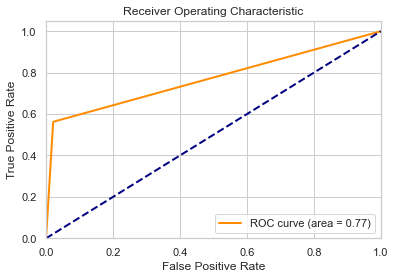

In [297]:
plot_roc(Y_test, Y_pred_log)

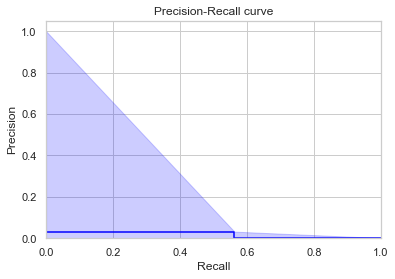

In [298]:
plot_pr(Y_test, Y_pred_log)

Conclusion: \
An AUC-ROC score of 0.77 is very high and indicates that the first model is highly effective at distinguishing between the two classes. It's a strong performance, suggesting that the model has a high true positive rate while keeping the false positive rate low.However, since this dataset is highly imbalanced, I also use AUC-PR score, which is a more imformatice metric. 

In this case, the AUC-PR score of 0.30. It means that the fist model is worse than random chance. 

## Section 3.2: Classification tree 

In [299]:
# create a decision tree classifier 
dt = DecisionTreeClassifier(random_state=27)

In [300]:
# Specify Hyperparameters for Tuning:
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [221]:
# Define the scoring metrics 
scoring_metrics = ['precision', 'recall', 'f1', 'roc_auc']

# Perform GridSearchCV with different scoring metrics
for scoring_metric in scoring_metrics:
    grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring=scoring_metric)
    grid_search.fit(X_train, Y_train)

    # Identify the best parameters and evaluate the model
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    score = grid_search.best_score_

    print(f"Scoring Metric: {scoring_metric}")
    print(f"Best Parameters: {best_params}")
    print(f"Best {scoring_metric} Score: {score:.4f}")

Scoring Metric: accuracy
Best Parameters: {'max_depth': 30, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 5}
Best accuracy Score: 0.9995
Scoring Metric: precision
Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5}
Best precision Score: 0.9425
Scoring Metric: recall
Best Parameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10}
Best recall Score: 0.7231
Scoring Metric: f1
Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2}
Best f1 Score: 0.7804
Scoring Metric: roc_auc
Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10}
Best roc_auc Score: 0.9437


According to the GridSearchCV results, I set the optimal max_depth to be 20, max_feature to be 'sqrt', min_sample_leaf to be 2, min_sample_split to be 5

In [301]:
# Perform GridSearchCV with different scoring metrics
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='precision')
   

In [302]:
grid_search.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=27),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='precision')

In [303]:
# Identify the best parameters and evaluate the model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
score = grid_search.best_score_

In [304]:
best_model_fit_dt = best_model.fit(X_train, Y_train)

In [309]:
y_pred_dt = best_model_fit_dt.predict(X_test)

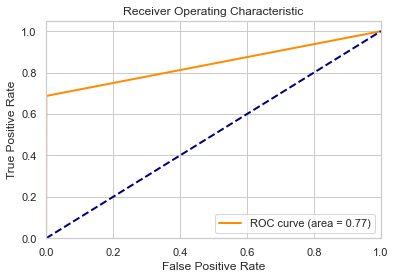

In [306]:
plot_roc(Y_test, y_pred_dt)

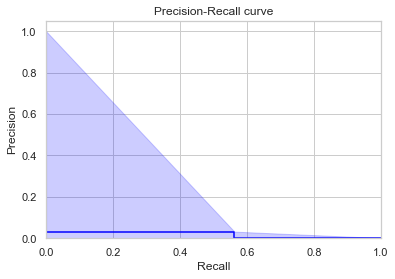

In [311]:
plot_pr(Y_test, y_pred_dt)

In [312]:
evaluate_model_roc_pr(best_model_fit_dt, X_test, Y_test)

AUC-ROC is:  0.8435139653815893
AUC-PR is:  0.667475859980956


(None, None)

In [308]:
dt_metrics = evaluate_model(best_model_fit_dt, X_test, Y_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12710
           1       0.65      0.69      0.67        16

    accuracy                           1.00     12726
   macro avg       0.82      0.84      0.83     12726
weighted avg       1.00      1.00      1.00     12726



Compared to basic logistic regression, the AUC-ROC score is increased from 0.77 to 0.84, the AUC-PR is increased from 0.3 to 0.67. Both the precision and recall scores are close to 0.70. 

## Section 3.3: XGBoost

In [313]:
import xgboost as xgb

In [330]:
param_grid = {
    'learning_rate': [0.01,0.015,0.02],
    'n_estimators': [5,10,20],
    'max_depth': [3, 4,5],
}

In [315]:
xgb_classifier = xgb.XGBClassifier()

In [331]:
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=5, scoring='precision')

In [332]:
grid_search.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=Non

In [333]:
best_params = grid_search.best_params_
best_xgb_model = grid_search.best_estimator_

In [334]:
best_model_fit_xgb = best_xgb_model.fit(X_train, Y_train)

In [335]:
y_pred_xgb = best_model_fit_xgb.predict(X_test)

In [336]:
evaluate_model_roc_pr(best_model_fit_xgb, X_test, Y_test)

AUC-ROC is:  0.59375
AUC-PR is:  0.5942607653622505


(None, None)

In [337]:
xgb_metrics = evaluate_model(best_model_fit_xgb, X_test, Y_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12710
           1       1.00      0.19      0.32        16

    accuracy                           1.00     12726
   macro avg       1.00      0.59      0.66     12726
weighted avg       1.00      1.00      1.00     12726



Compared to Decision Tree, the AUC for both ROC and PR decreased. The XGBoost optimizes the precision score to 1, but the recall score is decreased to 0.19.Therefore, decision tree is a better choice. 